In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pickle
import numpy as np

import py21cmfast as p21c
from astropy.cosmology import Planck18

sys.path.append("..")
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve
import dm21cm.physics as phys

sys.path.append(os.environ['DH_DIR'])
from darkhistory.main import evolve as evolve_DH

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc_file('../matplotlibrc')

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## DMParam

In [2]:
run_name = 'phph_base'

dm_params = DMParams(
    mode = 'swave',
    primary = 'phot_delta',
    m_DM = 1e10,
    sigmav = 1e-23,
    struct_boost_model = 'erfc 1e-3',
)

## DarkHistory

In [16]:
soln = evolve_DH(
    DM_process=dm_params.mode, mDM=dm_params.m_DM,
    primary=dm_params.primary,
    sigmav=dm_params.sigmav, lifetime=dm_params.lifetime,
    struct_boost=dm_params.struct_boost,
    start_rs=3000, end_rs=5.+1, coarsen_factor=12, verbose=1,
    reion_switch=False
)

pickle.dump(soln, open(f"../data/run_info/DH/{run_name}_soln.p", 'wb'))

****** Loading transfer functions... ******
Using data at /n/holyscratch01/iaifi_lab/yitians/darkhistory/DHdata_v1_1
    for propagating photons...  

 Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******
Loading time: 18.634 s


  0%|          | 0/518 [00:00<?, ?it/s]

Initialization time: 0.038 s


 10%|█         | 54/518 [00:09<01:25,  5.44it/s]/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
100%|██████████| 518/518 [01:38<00:00,  5.25it/s]

Main loop time: 98.613 s


In [3]:
return_dict = evolve(
    run_name = run_name,
    z_start = 45.,
    z_end = 40.,
    zplusone_step_factor = 1.01,
    dm_params = dm_params,
    enable_elec = False,
    tf_version = '230629',
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 64,
            BOX_LEN = 64 * 2, # [conformal Mpc]
            N_THREADS = 32,
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = Planck18.Om0,
            OMb = Planck18.Ob0,
            POWER_INDEX = Planck18.meta['n'],
            SIGMA_8 = Planck18.meta['sigma8'],
            hlittle = Planck18.h,
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    use_tqdm = True,
)

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230914
INFO:root:Cache dir: /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/phph_base
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA Interpreter
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO:root:TransferFunctionWrapper: Loaded photon transfer functions.
INFO:root:DarkHistoryWrapper: Found existing DarkHistory initial 

after:
spin_temp.Tk_box 41.490818
spin_temp.x_e_box 0.00021329575
ionized_box.xH_box 0.99978644


  0%|          | 0/12 [00:00<?, ?it/s]

before:
spin_temp.Tk_box 242.32993
spin_temp.x_e_box 0.005761361
ionized_box.xH_box 0.99423933
after:
spin_temp.Tk_box 43.69913
spin_temp.x_e_box 0.00025129644
ionized_box.xH_box 0.99974835


  8%|▊         | 1/12 [00:06<01:09,  6.32s/it]

before:
spin_temp.Tk_box 43.69913
spin_temp.x_e_box 0.00025129644
ionized_box.xH_box 0.99974835


 17%|█▋        | 2/12 [00:08<00:37,  3.79s/it]

after:
spin_temp.Tk_box 45.085865
spin_temp.x_e_box 0.00029977757
ionized_box.xH_box 0.9997005
before:
spin_temp.Tk_box 45.085865
spin_temp.x_e_box 0.00029977757
ionized_box.xH_box 0.9997005


 17%|█▋        | 2/12 [00:09<00:49,  4.94s/it]


KeyboardInterrupt: 

## compare

In [22]:
def plot_global(dh_soln, soln):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    color_dict = {
        'DH' : 'k',
        '21' : 'b'
    }

    ax = axs[0]
    ax.plot(dh_soln['rs'] - 1, dh_soln['Tm']/phys.kB, color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['T_k'], color=color_dict['21'], label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$T_k$ [K]', title='Gas temperature')
    ax.legend()

    ax = axs[1]
    ax.plot(dh_soln['rs'] - 1, dh_soln['x'][:, 0], color=color_dict['DH'], label='DarkHistory')
    ax.plot(soln['z'], soln['x_e'], color=color_dict['21'], label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log', yscale='log')
    ax.set(xlabel='$z$', ylabel='$x$', title='Ionization level')

    ax = axs[2]
    ax.plot(soln['z'], soln['T_b'], color=color_dict['21'], label='dm21cm')
    ax.set(xlim=(5, 50), xscale='log')
    ax.set(xlabel='$z$', ylabel='$T_b$ [K]', title='Brightness temperature')

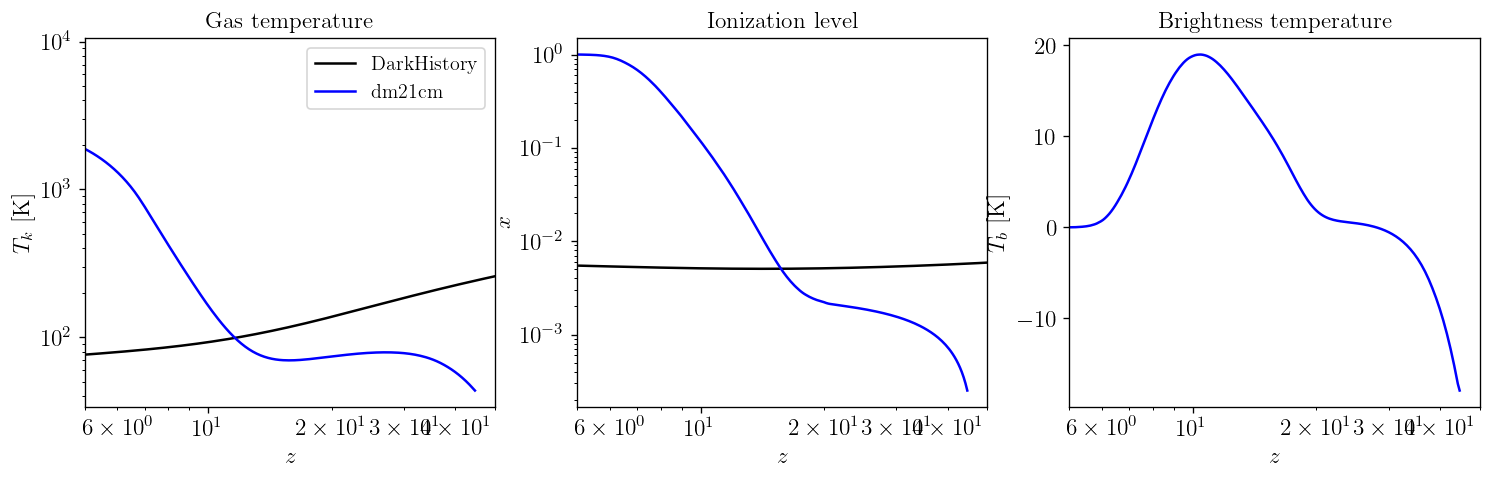

In [23]:
run_name = 'phph_base'
dh_soln = pickle.load(open(f"../data/run_info/DH/{run_name}_soln.p", 'rb'))
soln = np.load(f"../data/run_info/{run_name}_records.npy", allow_pickle=True).item()
plot_global(dh_soln, soln)

In [27]:
soln = pickle.load(open(os.environ['P21C_CACHE_DIR'] + '/' + run_name + '/dh_init_soln.p', 'rb'))

In [30]:
np.searchsorted(soln['rs'][::-1], 45)

7

In [31]:
soln['Tm'][::-1][7] / phys.kB

240.73062097369535

In [ ]:
spin_temp.Tk_box 41.490818
spin_temp.x_e_box 0.00021329575
ionized_box.xH_box 0.99978644
spin_temp.Tk_box 242.32993
spin_temp.x_e_box 0.005761361
ionized_box.xH_box 0.99423933
phot_bath_spec.toteng() 9.560496755492082